<a href="https://colab.research.google.com/github/m4riod14z/SkinDiseasesRNC/blob/main/EfficientNetV2B0_EarlyStopping%2C_ModelCheckpoint_y_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, itertools
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

plt.rcParams["figure.dpi"] = 120
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE = "/content/drive/MyDrive/SkinDiseasesRNC/Dataset"
TRAIN_DIR = os.path.join(BASE, "train")
TEST_DIR  = os.path.join(BASE, "test")

print("Train existe:", os.path.isdir(TRAIN_DIR))
print("Test  existe:", os.path.isdir(TEST_DIR))

Train existe: True
Test  existe: True


In [ ]:
IMG_SIZE = (384, 384)
BATCH = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    validation_split=0.20, subset="training", seed=SEED
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    validation_split=0.20, subset="validation", seed=SEED
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH, shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases (orden):", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

Found 1045 files belonging to 4 classes.
Using 836 files for training.
Found 1045 files belonging to 4 classes.
Using 209 files for validation.
Found 447 files belonging to 4 classes.
Clases (orden): ['Acne', 'Atopic_Dermatitis', 'Psoriasis', 'Rosacea']


In [ ]:
base = keras.applications.EfficientNetV2B0(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,)
)
base.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = keras.applications.efficientnet_v2.preprocess_input(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="efficientnetV2B0_fase1")

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "efficientnetV2B0_fase1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 12, 12, 1280)   │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,083,796 (23.21 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
# Entrenamiento con EarlyStopping + Checkpoint
PATH = "/content/drive/MyDrive/efficienteNetV2B0_best.keras"

callbacksTrain = [
    keras.callbacks.ModelCheckpoint(
        PATH, monitor="val_accuracy", mode="max",
        save_best_only=True, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
]

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacksTrain
)

Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5876 - loss: 0.9688
Epoch 1: val_accuracy improved from -inf to 0.86603, saving model to /content/drive/MyDrive/efficienteNetV2B0_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.5892 - loss: 0.9654 - val_accuracy: 0.8660 - val_loss: 0.4317
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8026 - loss: 0.5128
Epoch 2: val_accuracy improved from 0.86603 to 0.88995, saving model to /content/drive/MyDrive/efficienteNetV2B0_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.8025 - loss: 0.5124 - val_accuracy: 0.8900 - val_loss: 0.3612
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8489 - loss: 0.4123
Epoch 3: val_accuracy did not improve from 0.88995
53/53 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.8490 - loss: 0.4117 - val_accuracy: 0.8852 - val_loss: 0.3410
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8814 - loss: 0.3282
Epoch 4: val_accuracy im

In [ ]:
base.trainable = True

for layer in base.layers[:-50]:
    layer.trainable = False
for layer in base.layers[-50:]:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Entrenamiento de fine-tuning
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacksTrain
)

Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9438 - loss: 0.1898
Epoch 1: val_accuracy did not improve from 0.91388
53/53 ━━━━━━━━━━━━━━━━━━━━ 231s 4s/step - accuracy: 0.9439 - loss: 0.1896 - val_accuracy: 0.8995 - val_loss: 0.2963
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9440 - loss: 0.1738
Epoch 2: val_accuracy did not improve from 0.91388
53/53 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.9443 - loss: 0.1735 - val_accuracy: 0.8995 - val_loss: 0.2971
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9567 - loss: 0.1460
Epoch 3: val_accuracy did not improve from 0.91388
53/53 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.9568 - loss: 0.1458 - val_accuracy: 0.9043 - val_loss: 0.2915
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9629 - loss: 0.1360
Epoch 4: val_accuracy did not improve from 0.91388
53/53 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.9630 - loss: 0.1358 - val_accuracy: 0.9043 - val_loss: 0.2986


In [ ]:
best = keras.models.load_model(PATH)

In [ ]:
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
probs = best.predict(test_ds, verbose=0)
y_pred = probs.argmax(axis=1)

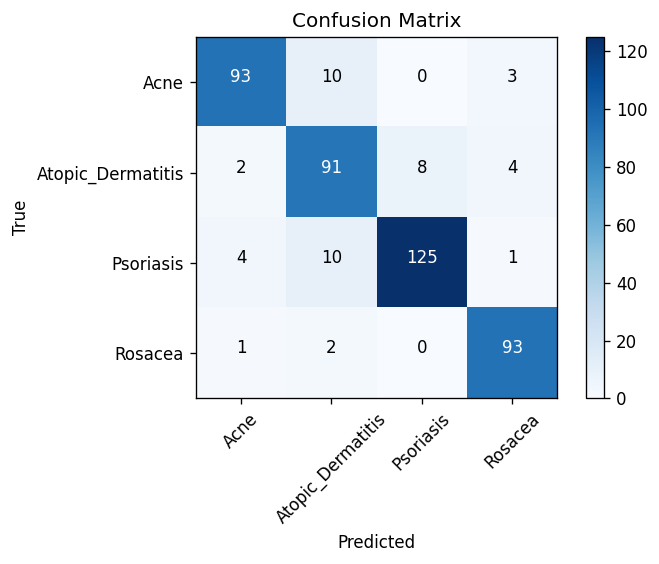

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)
th = cm.max() / 2.0
for i, j in itertools.product(range(num_classes), range(num_classes)):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > th else "black")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

                   precision    recall  f1-score   support

             Acne     0.9300    0.8774    0.9029       106
Atopic_Dermatitis     0.8053    0.8667    0.8349       105
        Psoriasis     0.9398    0.8929    0.9158       140
          Rosacea     0.9208    0.9688    0.9442        96

         accuracy                         0.8993       447
        macro avg     0.8990    0.9014    0.8994       447
     weighted avg     0.9018    0.8993    0.8998       447



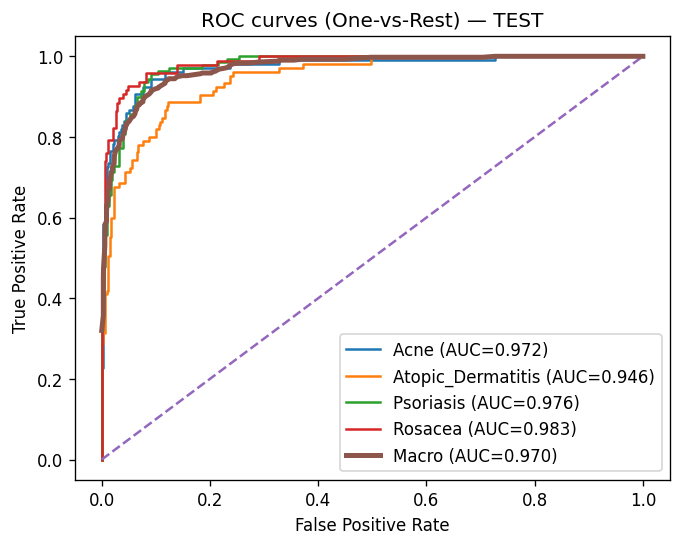

In [ ]:
# 11) Curvas ROC OvR + AUC macro
y_bin = label_binarize(y_true, classes=list(range(num_classes)))  # (N, C)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure()
for i, name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f"{name} (AUC={roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], '--')
plt.plot(all_fpr, mean_tpr, label=f"Macro (AUC={roc_auc['macro']:.3f})", linewidth=3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (One-vs-Rest) — TEST")
plt.legend()
plt.show()